# Data Science Project: Information Retrieval Engine
## Phase 1: Retrieval Basics

**Team Members:** Yannis Hemdane, Rayan Khatim, Nour el imene Khelassi, Aya Chihoub

**Phase 1 Deadline:** March 2, 2026, 11:59 PM

---

### Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading & Preparation](#2-data-loading--preparation)
3. [Data Analysis & Statistics](#3-data-analysis--statistics)
4. [Retrieval Methods](#4-retrieval-methods)
   - 4.1 TF-IDF Retrieval
   - 4.2 BM25+ Retrieval
   - 4.3 Text Embeddings (SentenceTransformers)
5. [Visualization](#5-visualization)
6. [Evaluation Suite](#6-evaluation-suite)
7. [Results Comparison](#7-results-comparison)
8. [Kaggle Submission](#8-kaggle-submission)

---
## 1. Setup & Imports

In [1]:
# Install required packages
!pip install pandas numpy scikit-learn rank_bm25 sentence-transformers umap-learn matplotlib seaborn tqdm -q


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Core imports
import json
import pandas as pd
import numpy as np
import re
import pickle
from pathlib import Path

# Retrieval methods
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Plus

# Embeddings
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

# Progress bars
from tqdm import tqdm

# Settings
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All imports successful!")

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful!


---
## 2. Data Loading & Preparation

The dataset consists of:
- **Documents (docs.json)**: The document collection with id, title, text, tags, and category
- **Training Queries (queries_train.json)**: Queries for evaluation
- **Test Queries (queries_test.json)**: Queries for Kaggle submission
- **Ground Truth (qgts_train.json)**: Relevant document IDs for each training query

In [3]:
# ============================================================
# IMPORTANT: Download data from Kaggle first!
# ============================================================
# 1. Go to: https://www.kaggle.com/t/f383bc6c1f194226bb43d21ab3d65418
# 2. Download and extract the dataset files to the 'data/' folder:
#    - docs.json
#    - queries_train.json  
#    - queries_test.json
#    - qgts_train.json
# ============================================================

DATA_DIR = Path('data/retrieval-engine-competition')

# Check if data files exist
required_files = ['docs.json', 'queries_train.json', 'queries_test.json', 'qgts_train.json']
missing = [f for f in required_files if not (DATA_DIR / f).exists()]

if missing:
    print("❌ Missing data files in 'data/' folder:")
    for f in missing:
        print(f"   - {f}")
    print("\n📥 Please download from Kaggle:")
    print("   https://www.kaggle.com/t/f383bc6c1f194226bb43d21ab3d65418")
else:
    # Load the data
    df_docs = pd.read_json(DATA_DIR / 'docs.json')
    df_queries_train = pd.read_json(DATA_DIR / 'queries_train.json')
    df_queries_test = pd.read_json(DATA_DIR / 'queries_test.json')

    with open(DATA_DIR / 'qgts_train.json', 'r') as f:
        ground_truth = json.load(f)

    print(f"✅ Data loaded successfully!")
    print(f"   Documents: {len(df_docs):,}")
    print(f"   Training Queries: {len(df_queries_train):,}")
    print(f"   Test Queries: {len(df_queries_test):,}")
    print(f"   Ground Truth entries: {len(ground_truth):,}")

✅ Data loaded successfully!
   Documents: 216,041
   Training Queries: 327
   Test Queries: 141
   Ground Truth entries: 327


In [4]:
# Preview the data
print("📄 Sample Document:")
display(df_docs.head(2))

print("\n❓ Sample Query:")
display(df_queries_train.head(2))

📄 Sample Document:


,id,text,title,tags,category
0,6970cbf2-ffff-4c7b-b73d-52524000c232_145427,I try to install Complete MiKTeX 2.9 But there is this: Error: The operation could not be comple...,MikTex Download Failure - toptesi.tar.lzma,[miktex],tex
1,667220d0-66be-4059-ae60-b9df15d285f7_77850,I'm trying to get a launcher working for the WikidPad (python) program. I already have a pytho...,Launcher for a Python program that requires extra libraries,"[gnome3, python, path, cd]",unix



❓ Sample Query:


,id,text,title,tags,category
0,961c4349-8cf1-4ef1-89cc-24d20bb9d000_67878,Want to try reformatting Damaged SD Card,,"[linux, development]",android
1,4008ed78-e66e-4d89-9c3b-c79bd1cf6fc9_366,"Convince grep to output all lines, not just those with matches",,"[shell, virtualization, storage, cluster]",unix


### 2.1 Text Preprocessing

We create a unified `content` field by merging title, text, and tags. This gives the retrieval models more context to work with.

In [5]:
def merge_fields(row):
    """Combine title, text, and tags into a single content field."""
    title = str(row.get('title', '') or '')
    text = str(row.get('text', '') or '')
    tags_list = row.get('tags', [])
    tags = " ".join(tags_list) if isinstance(tags_list, list) else ""
    
    combined = f"{title} {text} {tags}"
    return " ".join(combined.split())  # Normalize whitespace

def clean_text(text):
    """Clean text: lowercase and remove punctuation."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply preprocessing
print("Processing documents...")
df_docs['content'] = df_docs.apply(merge_fields, axis=1)
df_docs['content_clean'] = df_docs['content'].apply(clean_text)

print("Processing training queries...")
df_queries_train['content'] = df_queries_train.apply(merge_fields, axis=1)
df_queries_train['content_clean'] = df_queries_train['content'].apply(clean_text)

print("Processing test queries...")
df_queries_test['content'] = df_queries_test.apply(merge_fields, axis=1)
df_queries_test['content_clean'] = df_queries_test['content'].apply(clean_text)

print("✅ Text preprocessing complete!")

Processing documents...
Processing training queries...
Processing test queries...
✅ Text preprocessing complete!


---
## 3. Data Analysis & Statistics

Before building our retrieval system, let's understand our dataset better.

In [6]:
# Basic statistics
print("="*60)
print("📊 DATASET STATISTICS")
print("="*60)

print(f"\n📄 DOCUMENTS:")
print(f"   Total documents: {len(df_docs):,}")
print(f"   Columns: {list(df_docs.columns)}")

print(f"\n❓ QUERIES:")
print(f"   Training queries: {len(df_queries_train):,}")
print(f"   Test queries: {len(df_queries_test):,}")

print(f"\n🎯 RELEVANCE JUDGMENTS:")
total_relevant = sum(len(v) for v in ground_truth.values())
avg_relevant = total_relevant / len(ground_truth)
print(f"   Total relevance judgments: {total_relevant:,}")
print(f"   Average relevant docs per query: {avg_relevant:.2f}")

📊 DATASET STATISTICS

📄 DOCUMENTS:
   Total documents: 216,041
   Columns: ['id', 'text', 'title', 'tags', 'category', 'content', 'content_clean']

❓ QUERIES:
   Training queries: 327
   Test queries: 141

🎯 RELEVANCE JUDGMENTS:
   Total relevance judgments: 981
   Average relevant docs per query: 3.00


In [7]:
# Document length statistics
df_docs['content_length'] = df_docs['content'].str.split().str.len()
df_queries_train['content_length'] = df_queries_train['content'].str.split().str.len()

print("\n📏 CONTENT LENGTH STATISTICS:")
print("\nDocuments:")
print(df_docs['content_length'].describe())

print("\nQueries:")
print(df_queries_train['content_length'].describe())


📏 CONTENT LENGTH STATISTICS:

Documents:
count    216041.000000
mean        137.182234
std         146.971431
min           9.000000
25%          64.000000
50%         100.000000
75%         161.000000
max        5256.000000
Name: content_length, dtype: float64

Queries:
count    327.000000
mean      11.437309
std        3.902361
min        3.000000
25%        9.000000
50%       11.000000
75%       13.000000
max       31.000000
Name: content_length, dtype: float64



📂 CATEGORY DISTRIBUTION:
category
tex            68184
unix           47382
gaming         45301
programmers    32176
android        22998
Name: count, dtype: int64


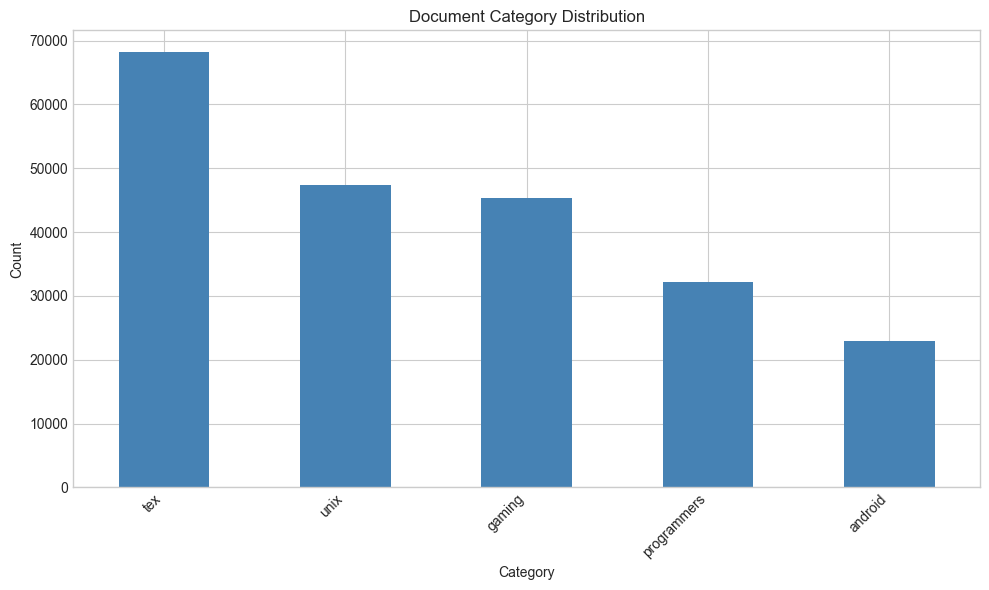

In [8]:
# Category distribution (if available)
if 'category' in df_docs.columns:
    print("\n📂 CATEGORY DISTRIBUTION:")
    category_counts = df_docs['category'].value_counts()
    print(category_counts)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    category_counts.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Document Category Distribution')
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('reports/category_distribution.png', dpi=150)
    plt.show()

---
## 4. Retrieval Methods

We implement three retrieval methods:
1. **TF-IDF** - Term Frequency-Inverse Document Frequency
2. **BM25+** - Best Matching 25 Plus
3. **Text Embeddings** - Using SentenceTransformers

### 4.1 TF-IDF Retrieval

**How TF-IDF works:**

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates how important a word is to a document in a collection.

- **TF (Term Frequency)**: How often a word appears in a document. More occurrences = higher importance.
- **IDF (Inverse Document Frequency)**: How rare a word is across all documents. Rare words get higher scores.

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log\left(\frac{N}{\text{DF}(t)}\right)$$

Where:
- $t$ = term, $d$ = document, $N$ = total documents, $\text{DF}(t)$ = documents containing term $t$

We use **cosine similarity** to compare query and document vectors.

In [9]:
# TF-IDF Retrieval
print("Building TF-IDF model...")

# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100000)

# Fit on documents
tfidf_doc_matrix = tfidf_vectorizer.fit_transform(df_docs['content_clean'])
print(f"TF-IDF Document Matrix Shape: {tfidf_doc_matrix.shape}")

# Transform queries
tfidf_query_matrix = tfidf_vectorizer.transform(df_queries_train['content_clean'])
print(f"TF-IDF Query Matrix Shape: {tfidf_query_matrix.shape}")

Building TF-IDF model...
TF-IDF Document Matrix Shape: (216041, 100000)
TF-IDF Query Matrix Shape: (327, 100000)


In [10]:
def retrieve_topk_tfidf(query_matrix, doc_matrix, doc_ids, k=10):
    """Retrieve top-k documents for each query using TF-IDF + cosine similarity."""
    topk_indices = []
    topk_scores = []
    
    # Compute similarities
    similarities = cosine_similarity(query_matrix, doc_matrix)
    
    for i in tqdm(range(similarities.shape[0]), desc="TF-IDF Retrieval"):
        scores = similarities[i]
        top_idx = np.argsort(scores)[-k:][::-1]
        
        topk_indices.append([doc_ids[j] for j in top_idx])
        topk_scores.append(scores[top_idx].tolist())
    
    return topk_indices, topk_scores

# Retrieve
K = 10
doc_ids = df_docs['id'].tolist()

topk_indices_tfidf, topk_scores_tfidf = retrieve_topk_tfidf(
    tfidf_query_matrix, tfidf_doc_matrix, doc_ids, k=K
)

print(f"\n✅ TF-IDF retrieval complete!")
print(f"Sample result for query 0: {topk_indices_tfidf[0][:3]}...")

TF-IDF Retrieval: 100%|██████████| 327/327 [00:01<00:00, 189.68it/s]


✅ TF-IDF retrieval complete!
Sample result for query 0: ['cbac6e51-ea52-4824-be99-93db1abbe35a_62218', '6260dea3-8a5e-4e28-8c8e-9340f9352887_23121', 'a1fdd2bb-79eb-4dc5-8671-afca8cd3dac3_44409']...


### 4.2 BM25+ Retrieval

**How BM25+ works:**

BM25+ is a ranking function used by search engines. It improves on TF-IDF by:
- Adding **saturation**: Term frequency impact diminishes for very frequent terms
- **Document length normalization**: Prevents bias towards longer documents
- **+** variant adds a small constant to prevent zero scores

$$\text{BM25+}(q, d) = \sum_{t \in q} \text{IDF}(t) \cdot \frac{f(t, d) \cdot (k_1 + 1)}{f(t, d) + k_1 \cdot (1 - b + b \cdot \frac{|d|}{\text{avgdl}})} + \delta$$

Parameters:
- $k_1$ (typically 1.2-2.0): Controls term frequency saturation
- $b$ (typically 0.75): Controls document length normalization
- $\delta$ (typically 1): Lower bound for term weight

In [11]:
# BM25+ Retrieval
print("Building BM25+ model...")

# Tokenize corpus
tokenized_corpus = [doc.split() for doc in df_docs['content_clean']]

# Initialize BM25+
bm25_model = BM25Plus(tokenized_corpus)

print(f"✅ BM25+ model built on {len(tokenized_corpus):,} documents")

Building BM25+ model...
✅ BM25+ model built on 216,041 documents


In [12]:
def retrieve_topk_bm25(queries, bm25, doc_ids, k=10):
    """Retrieve top-k documents for each query using BM25+."""
    topk_indices = []
    topk_scores = []
    
    for query in tqdm(queries, desc="BM25+ Retrieval"):
        tokenized_query = query.split()
        scores = bm25.get_scores(tokenized_query)
        
        top_idx = np.argsort(scores)[-k:][::-1]
        
        topk_indices.append([doc_ids[j] for j in top_idx])
        topk_scores.append(scores[top_idx].tolist())
    
    return topk_indices, topk_scores

# Retrieve
topk_indices_bm25, topk_scores_bm25 = retrieve_topk_bm25(
    df_queries_train['content_clean'].tolist(), bm25_model, doc_ids, k=K
)

print(f"\n✅ BM25+ retrieval complete!")
print(f"Sample result for query 0: {topk_indices_bm25[0][:3]}...")

BM25+ Retrieval: 100%|██████████| 327/327 [04:28<00:00,  1.22it/s]


✅ BM25+ retrieval complete!
Sample result for query 0: ['276bf1e2-20da-4758-9009-d2472ad21266_17022', '6260dea3-8a5e-4e28-8c8e-9340f9352887_23121', 'a1fdd2bb-79eb-4dc5-8671-afca8cd3dac3_44409']...


### 4.3 Text Embeddings (SentenceTransformers)

**What are embeddings and why use them?**

Text embeddings are dense vector representations that capture the **semantic meaning** of text. Unlike TF-IDF/BM25 which rely on exact word matching, embeddings can:

1. **Understand synonyms**: "car" and "automobile" have similar embeddings
2. **Capture context**: "bank" (financial) vs "bank" (river) get different representations
3. **Handle paraphrases**: Different phrasings of the same idea are close in vector space

We use **SentenceTransformers** which are pre-trained models specifically designed for semantic similarity tasks.

**Model**: `all-MiniLM-L6-v2` - A good balance of speed and quality

In [13]:
# Load SentenceTransformer model
print("Loading SentenceTransformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"✅ Model loaded!")
print(f"   Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

Loading SentenceTransformer model...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 580.84it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded!
   Embedding dimension: 384


In [14]:
# Generate document embeddings (this may take a while for large datasets)
print("Generating document embeddings...")
print("⚠️ This may take several minutes for large datasets. Consider using GPU.")

# Use original content (not cleaned) for better semantic understanding
doc_embeddings = embedding_model.encode(
    df_docs['content'].tolist(),
    show_progress_bar=True,
    batch_size=64
)

print(f"\n✅ Document embeddings shape: {doc_embeddings.shape}")

Generating document embeddings...
⚠️ This may take several minutes for large datasets. Consider using GPU.


Batches:  27%|██▋       | 906/3376 [1:16:47<3:29:21,  5.09s/it] 


KeyboardInterrupt: 

In [ ]:
# Generate query embeddings
print("Generating query embeddings...")

query_embeddings_train = embedding_model.encode(
    df_queries_train['content'].tolist(),
    show_progress_bar=True,
    batch_size=64
)

print(f"\n✅ Query embeddings shape: {query_embeddings_train.shape}")

In [ ]:
def retrieve_topk_embeddings(query_emb, doc_emb, doc_ids, k=10):
    """Retrieve top-k documents using embedding similarity."""
    topk_indices = []
    topk_scores = []
    
    # Compute cosine similarities
    similarities = cosine_similarity(query_emb, doc_emb)
    
    for i in tqdm(range(len(query_emb)), desc="Embedding Retrieval"):
        scores = similarities[i]
        top_idx = np.argsort(scores)[-k:][::-1]
        
        topk_indices.append([doc_ids[j] for j in top_idx])
        topk_scores.append(scores[top_idx].tolist())
    
    return topk_indices, topk_scores

# Retrieve
topk_indices_emb, topk_scores_emb = retrieve_topk_embeddings(
    query_embeddings_train, doc_embeddings, doc_ids, k=K
)

print(f"\n✅ Embedding retrieval complete!")
print(f"Sample result for query 0: {topk_indices_emb[0][:3]}...")

---
## 5. Visualization

We use dimensionality reduction (t-SNE or UMAP) to visualize our embeddings in 2D and analyze category clustering.

In [ ]:
# Sample embeddings for visualization (full dataset would be too slow)
SAMPLE_SIZE = 5000

# Random sample
np.random.seed(42)
sample_idx = np.random.choice(len(doc_embeddings), min(SAMPLE_SIZE, len(doc_embeddings)), replace=False)

sample_embeddings = doc_embeddings[sample_idx]
sample_categories = df_docs.iloc[sample_idx]['category'].values if 'category' in df_docs.columns else None

print(f"Sampled {len(sample_embeddings)} documents for visualization")

In [ ]:
# t-SNE visualization
print("Running t-SNE dimensionality reduction...")
print("⚠️ This may take a few minutes...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(sample_embeddings)

print(f"✅ t-SNE complete! Output shape: {embeddings_2d_tsne.shape}")

In [ ]:
# Plot t-SNE results
fig, ax = plt.subplots(figsize=(12, 10))

if sample_categories is not None:
    # Color by category
    unique_cats = np.unique(sample_categories)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_cats)))
    
    for i, cat in enumerate(unique_cats):
        mask = sample_categories == cat
        ax.scatter(
            embeddings_2d_tsne[mask, 0],
            embeddings_2d_tsne[mask, 1],
            c=[colors[i]],
            label=cat,
            alpha=0.6,
            s=10
        )
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    ax.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], alpha=0.6, s=10)

ax.set_title('t-SNE Visualization of Document Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig('reports/tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# UMAP visualization (if available - often faster and better for large datasets)
if UMAP_AVAILABLE:
    print("Running UMAP dimensionality reduction...")
    
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_2d_umap = reducer.fit_transform(sample_embeddings)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    if sample_categories is not None:
        for i, cat in enumerate(unique_cats):
            mask = sample_categories == cat
            ax.scatter(
                embeddings_2d_umap[mask, 0],
                embeddings_2d_umap[mask, 1],
                c=[colors[i]],
                label=cat,
                alpha=0.6,
                s=10
            )
        ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.scatter(embeddings_2d_umap[:, 0], embeddings_2d_umap[:, 1], alpha=0.6, s=10)
    
    ax.set_title('UMAP Visualization of Document Embeddings')
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    plt.tight_layout()
    plt.savefig('reports/umap_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("UMAP not available. Install with: pip install umap-learn")

### Visualization Analysis

**Observations:**

*[Answer the following based on your visualizations:]*

1. **Do you notice any clustering?** 
   - *TODO: Describe whether documents form distinct clusters*

2. **Is there separation by category?**
   - *TODO: Describe if different categories occupy different regions*

3. **Why might this happen?**
   - *TODO: Explain based on how embeddings capture semantic meaning*

---
## 6. Evaluation Suite

We evaluate our retrieval systems using three standard metrics:
- **Recall**: Did we find the relevant documents?
- **Precision**: Are the retrieved documents relevant?
- **MRR (Mean Reciprocal Rank)**: How early do relevant documents appear?

In [ ]:
def compute_recall(retrieved_ids, relevant_ids):
    """
    Compute Recall@k.
    
    Recall = # of relevant documents retrieved / # of total relevant documents
    
    Answers: Did the system find the documents that matter?
    """
    if len(relevant_ids) == 0:
        return 0.0
    
    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids)
    
    return len(retrieved_set & relevant_set) / len(relevant_set)


def compute_precision(retrieved_ids, relevant_ids):
    """
    Compute Precision@k.
    
    Precision = # of relevant documents retrieved / # of total retrieved documents
    
    Answers: Are the top results useful?
    """
    if len(retrieved_ids) == 0:
        return 0.0
    
    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids)
    
    return len(retrieved_set & relevant_set) / len(retrieved_ids)


def compute_mrr(retrieved_ids, relevant_ids):
    """
    Compute Mean Reciprocal Rank.
    
    MRR = 1 / rank of first relevant document
    
    Answers: How early does a relevant document appear?
    """
    relevant_set = set(relevant_ids)
    
    for rank, doc_id in enumerate(retrieved_ids, start=1):
        if doc_id in relevant_set:
            return 1.0 / rank
    
    return 0.0  # No relevant document found


print("✅ Evaluation functions defined!")

In [ ]:
def evaluate_retrieval(topk_indices, ground_truth, query_ids):
    """
    Evaluate a retrieval method across all queries.
    
    Returns:
        dict with average recall, precision, and MRR
    """
    recalls = []
    precisions = []
    mrrs = []
    
    for i, query_id in enumerate(query_ids):
        retrieved = topk_indices[i]
        relevant = ground_truth.get(query_id, [])
        
        recalls.append(compute_recall(retrieved, relevant))
        precisions.append(compute_precision(retrieved, relevant))
        mrrs.append(compute_mrr(retrieved, relevant))
    
    return {
        'Recall@k': np.mean(recalls),
        'Precision@k': np.mean(precisions),
        'MRR': np.mean(mrrs),
        'recalls': recalls,
        'precisions': precisions,
        'mrrs': mrrs
    }

print("✅ Evaluation framework ready!")

In [ ]:
# Evaluate all methods
query_ids = df_queries_train['id'].tolist()

print(f"Evaluating retrieval methods (k={K})...")
print("="*60)

# TF-IDF
results_tfidf = evaluate_retrieval(topk_indices_tfidf, ground_truth, query_ids)
print(f"\n📊 TF-IDF Results:")
print(f"   Recall@{K}: {results_tfidf['Recall@k']:.4f}")
print(f"   Precision@{K}: {results_tfidf['Precision@k']:.4f}")
print(f"   MRR: {results_tfidf['MRR']:.4f}")

# BM25+
results_bm25 = evaluate_retrieval(topk_indices_bm25, ground_truth, query_ids)
print(f"\n📊 BM25+ Results:")
print(f"   Recall@{K}: {results_bm25['Recall@k']:.4f}")
print(f"   Precision@{K}: {results_bm25['Precision@k']:.4f}")
print(f"   MRR: {results_bm25['MRR']:.4f}")

# Embeddings
results_emb = evaluate_retrieval(topk_indices_emb, ground_truth, query_ids)
print(f"\n📊 Embeddings Results:")
print(f"   Recall@{K}: {results_emb['Recall@k']:.4f}")
print(f"   Precision@{K}: {results_emb['Precision@k']:.4f}")
print(f"   MRR: {results_emb['MRR']:.4f}")

---
## 7. Results Comparison

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': ['TF-IDF', 'BM25+', 'Embeddings'],
    f'Recall@{K}': [
        results_tfidf['Recall@k'],
        results_bm25['Recall@k'],
        results_emb['Recall@k']
    ],
    f'Precision@{K}': [
        results_tfidf['Precision@k'],
        results_bm25['Precision@k'],
        results_emb['Precision@k']
    ],
    'MRR': [
        results_tfidf['MRR'],
        results_bm25['MRR'],
        results_emb['MRR']
    ]
})

print("\n" + "="*60)
print("📊 RESULTS COMPARISON")
print("="*60)
display(comparison_df)

# Save results
comparison_df.to_csv('reports/evaluation_results.csv', index=False)
print("\n✅ Results saved to reports/evaluation_results.csv")

In [ ]:
# Visualization of results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = [f'Recall@{K}', f'Precision@{K}', 'MRR']
colors = ['#2ecc71', '#3498db', '#9b59b6']

for ax, metric, color in zip(axes, metrics, colors):
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Method'], values, color=color, alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=11)
    
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.2)
    ax.set_ylabel('Score')

plt.suptitle('Retrieval Methods Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('reports/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Results Analysis

**Questions to answer:**

1. **Which model performs best overall?**
   - *TODO: Compare and discuss*

2. **Why might one model outperform others?**
   - *TODO: Discuss strengths/weaknesses of each approach*

3. **What are the trade-offs?**
   - *TODO: Consider speed, accuracy, and resource requirements*

4. **How does changing k affect results?**
   - *TODO: Experiment and discuss*

---
## 8. Kaggle Submission

Generate predictions for the test queries and create submission file.

In [ ]:
# Generate predictions for test queries using best method
# (Choose based on evaluation results)

print("Generating predictions for test queries...")

# Transform test queries
test_query_matrix = tfidf_vectorizer.transform(df_queries_test['content_clean'])

# Retrieve (using TF-IDF as example - change to best method)
test_topk_indices, test_topk_scores = retrieve_topk_tfidf(
    test_query_matrix, tfidf_doc_matrix, doc_ids, k=K
)

print(f"✅ Generated predictions for {len(test_topk_indices)} test queries")

In [ ]:
# Create submission file
submission = {
    query_id: retrieved
    for query_id, retrieved in zip(df_queries_test['id'].tolist(), test_topk_indices)
}

# Save
with open('submission_phase1.json', 'w') as f:
    json.dump(submission, f)

print("✅ Submission file created: submission_phase1.json")
print(f"   Total queries: {len(submission)}")

In [ ]:
# Save all results for later use
results = {
    'topk_indices_tfidf': topk_indices_tfidf,
    'topk_scores_tfidf': topk_scores_tfidf,
    'topk_indices_bm25': topk_indices_bm25,
    'topk_scores_bm25': topk_scores_bm25,
    'topk_indices_emb': topk_indices_emb,
    'topk_scores_emb': topk_scores_emb,
    'evaluation_results': {
        'tfidf': results_tfidf,
        'bm25': results_bm25,
        'embeddings': results_emb
    }
}

with open('all_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("✅ All results saved to all_results.pkl")